In [38]:
import warnings
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D,Dropout, BatchNormalization
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils, to_categorical
from keras import backend as K
from keras import optimizers

In [3]:
# load dataset list

train_data = pd.read_csv("train_vision.csv")
train_filename = train_data["filename"].values.tolist()
train_data["label"] = train_data["label"] -1
train_label = train_data["label"].values.tolist()

test_data = pd.read_csv("test_vision.csv")
test_filename = test_data["filename"].values.tolist()

print(len(train_filename), len(train_label), len(test_filename))

5850 5850 2000


In [4]:
# load train data
input_height , input_width = 128, 128
n_class = 6

def getImageArr(img_name):
        img = cv2.imread("faces_images/" + img_name, 1)
        img = np.float32(img) / 127.5 - 1   #0~255 를 평균 0이게 수정
        return img

X = []
for name in train_filename:
    X.append(getImageArr(name))
    
X, Y = np.array(X), to_categorical(np.array(train_label),n_class)
print(X.shape, Y.shape)

(5850, 128, 128, 3) (5850, 6)


In [5]:
# split dataset

train_rate = 0.85
index_train = np.random.choice(X.shape[0],int(X.shape[0]*train_rate),replace=False)
index_test  = list(set(range(X.shape[0])) - set(index_train))
                            
# X, Y = shuffle(X,Y)
X_train, y_train = X[index_train],Y[index_train]
X_test, y_test = X[index_test],Y[index_test]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4972, 128, 128, 3) (4972, 6)
(878, 128, 128, 3) (878, 6)


In [6]:
# load test data

real_test = []
for name in test_filename:
    real_test.append(getImageArr(name))
    
real_test = np.array(real_test)
print(real_test.shape)

(2000, 128, 128, 3)


In [43]:
 def nn_base(nClasses, input_height=128, input_width=128):
        
    img_input = Input(shape=(input_height,input_width, 3))
        
    IMAGE_ORDERING =  "channels_last" 
        
    ## Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', data_format=IMAGE_ORDERING )(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', data_format=IMAGE_ORDERING )(x)
    x = BatchNormalization(name='batchnorm1')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', data_format=IMAGE_ORDERING )(x)
    f1 = x
    
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', data_format=IMAGE_ORDERING )(x)
    f2 = x

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', data_format=IMAGE_ORDERING )(x)
    x = BatchNormalization(name='batchnorm3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool', data_format=IMAGE_ORDERING )(x)    
    pool3 = x

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', data_format=IMAGE_ORDERING )(x)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool', data_format=IMAGE_ORDERING )(x) 

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', data_format=IMAGE_ORDERING )(pool4)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', data_format=IMAGE_ORDERING )(x)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool', data_format=IMAGE_ORDERING )(x)
    
    # classification
    x = Flatten(name='flatten')(pool5)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dropout(0.3)(x)
    
    x = Dense(2048, activation='relu', name='fc2')(x)
    x = Dropout(0.3)(x)
    
    x = Dense(1024, activation='relu', name='fc3')(x)
#     x = Dropout(0.3)(x)
    
    x = Dense(512, activation='relu', name='fc4')(x)
#     x = Dropout(0.3)(x)
    
    x = Dense(256, activation='relu', name='fc5')(x)
#     x = Dropout(0.2)(x)
    
    x = Dense(n_class , activation='softmax', name='predictions')(x)
    
    model = Model(img_input, x)

    return model

In [44]:
model = nn_base(nClasses  = n_class,  
             input_height = 128, 
             input_width  = 128)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
batchnorm1 (BatchNormalizati (None, 128, 128, 64)      256       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
__________

In [45]:
with K.tf.device('/gpu:1'):
    sgd = optimizers.SGD(lr=1E-2, decay=5**(-4), momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])

    hist1 = model.fit(X_train,y_train,
                      validation_data=(X_test,y_test),
                      batch_size=32,epochs=15)

Train on 4972 samples, validate on 878 samples
Epoch 1/15
4972/4972 [==============================] - 23s 5ms/step - loss: 1.3742 - acc: 0.4799 - val_loss: 1.2519 - val_acc: 0.5718
Epoch 2/15
4972/4972 [==============================] - 20s 4ms/step - loss: 1.1530 - acc: 0.5925 - val_loss: 1.0172 - val_acc: 0.6538
Epoch 3/15
4972/4972 [==============================] - 20s 4ms/step - loss: 0.8510 - acc: 0.7019 - val_loss: 0.5875 - val_acc: 0.7813
Epoch 4/15
4972/4972 [==============================] - 20s 4ms/step - loss: 0.5016 - acc: 0.8198 - val_loss: 0.6294 - val_acc: 0.7585
Epoch 5/15
4972/4972 [==============================] - 20s 4ms/step - loss: 0.3970 - acc: 0.8578 - val_loss: 0.4243 - val_acc: 0.8428
Epoch 6/15
4972/4972 [==============================] - 21s 4ms/step - loss: 0.3129 - acc: 0.8882 - val_loss: 0.4430 - val_acc: 0.8383
Epoch 7/15
4972/4972 [==============================] - 20s 4ms/step - loss: 0.2550 - acc: 0.9103 - val_loss: 0.3997 - val_acc: 0.8667
Epoch 8/

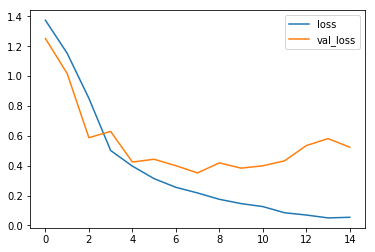

In [46]:
for key in ['loss', 'val_loss']:
    plt.plot(hist1.history[key],label=key)
plt.legend()
plt.show()

In [47]:
y_pred = model.predict(real_test)
y_predi = np.argmax(y_pred,axis = 1) + 1
print(np.unique(y_predi), y_predi.shape)

[1 2 3 4 5 6] (2000,)


In [48]:
answer = pd.DataFrame({"prediction":y_predi})

In [49]:
answer.to_csv('results/3-2.csv',index=False, header="label")

In [128]:
a = pd.read_csv('1-1.csv').reset_index()
b = pd.read_csv('test_vision.csv').reset_index()
c = pd.merge(a,b, on='index')
c[:50]

,index,prediction,filename
0,0,1,face_2624.png
1,1,1,face_3385.png
2,2,1,face_5015.png
3,3,1,face_6715.png
4,4,4,face_6171.png
5,5,4,face_3269.png
6,6,4,face_4942.png
7,7,5,face_1095.png
8,8,4,face_7721.png
9,9,1,face_2455.png
